In [1]:
import numpy as np
import pandas as pd
from os import path

data_directory = "synData28June"
lotti_fn = "export_lotti_veneto_2016_2018_giulio.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio.csv"

lotti = pd.read_csv(path.join(data_directory, lotti_fn))
vincitori = pd.read_csv(path.join(data_directory, vincitori_fn))

lotti.data_inizio = pd.to_datetime(lotti.data_inizio, yearfirst=True)
lotti.data_fine = pd.to_datetime(lotti.data_fine, yearfirst=True)

In [2]:
vincitori.dtypes

id_lotto               int64
ruolo                 object
id_be                  int64
id_forma_giuridica     int64
md5                   object
dtype: object

In [3]:
lotti.dtypes

id_lotto                            int64
oggetto                            object
id_scelta_contraente              float64
id_cpv                            float64
importo                           float64
importo_base_asta                 float64
importo_liquidato                 float64
data_inizio                datetime64[ns]
data_fine                  datetime64[ns]
data_inferita_calcolata              bool
id_lsf                            float64
id_mod_realizz                    float64
id_forma_giuridica                  int64
md5                                object
dtype: object

np.nan is float64, hence all id attributes are float. 

Ma cosa voglio farci? voglio riempirli con un valore? isolation forest, ad esempio, non funziona con i NaN. 

È importante che l'algoritmo funzioni, non che tutto sia concettualmente corretto.

la domanda successiva diventa: cosa metto nelle lacune?

* attributi categorici: vorrei che NaN fosse una categoria.
* attributi continui: 0. trattandosi di importi sembra ragionevole. eventualmente si può sempre cambiare.
* date: onenstamente non lo so. 

eliminare le features con troppi zeri? può una variabile quasi sempre vuota essere predittiva? potenzialmente sì, infatti è un outlier già di per sè. (si può parlare di outlier nel caso di variabili categoriche?)

In [4]:
len(lotti.id_cpv.unique())

3193

In [5]:
len(lotti.id_scelta_contraente.unique())

26

In [6]:
len(lotti.id_mod_realizz.unique())

13

In [7]:
np.sum(lotti.isna(), axis=0)

id_lotto                        0
oggetto                        37
id_scelta_contraente          174
id_cpv                     884070
importo                      1115
importo_base_asta          929553
importo_liquidato           56249
data_inizio                     0
data_fine                   53278
data_inferita_calcolata         0
id_lsf                      33487
id_mod_realizz             903220
id_forma_giuridica              0
md5                             0
dtype: int64

In [8]:
# Assuming that the cpv is given
lottiCPV = lotti[lotti.id_cpv.notna()]
np.sum(lottiCPV.isna(), axis=0)

id_lotto                       0
oggetto                        2
id_scelta_contraente           9
id_cpv                         0
importo                       87
importo_base_asta          58515
importo_liquidato          10802
data_inizio                    0
data_fine                   2882
data_inferita_calcolata        0
id_lsf                      2023
id_mod_realizz             19547
id_forma_giuridica             0
md5                            0
dtype: int64

In [9]:
lottiCPV.groupby("id_mod_realizz", dropna=False).size() # 13

id_mod_realizz
1.0     19618
3.0     10318
4.0       874
5.0        13
6.0        14
7.0         8
8.0         2
9.0        41
10.0       24
11.0      934
13.0      318
14.0    11716
NaN     19547
dtype: int64

In [10]:
lottiCPV.groupby("id_scelta_contraente", dropna=False).size() # 22

id_scelta_contraente
1.0      4210
2.0       437
3.0       311
4.0     11331
5.0        19
6.0      1828
7.0       248
8.0      7402
14.0     1246
17.0      241
21.0      190
22.0     1416
23.0    20834
24.0       62
25.0       14
26.0    13009
27.0      449
29.0       44
30.0       14
31.0      105
33.0        8
NaN         9
dtype: int64

In [11]:
lottiCPV.groupby("id_forma_giuridica").size().shape

(86,)

# Encoding nominal features
dopo una ricerca, opto per hashing encoding
* id_scelta_contrante: 21+NaN one-hot or  hashing
* id_cpv: 3193 hashing
* id_lsf: 3+NaN, one-hot
* id_mod_realizz: 12+NaN, one-hot
* id_forma_giuridica: 86, hashing

ma conviene considerarle come se fossere un'unica grande feature? Boh. Bisogna provare. 

# Encoding datetime
they are intrisically cyclic (but for year). possible choices:
* day-of-the-week
* day-of-the-month
* month

map them to sin cos and eventually consider the frequency domain (Fuorier transform)

Problema generale con i tree-based algorithms: considerano una feature alla volta, quindi è più conveniente avere un numero inferiore di features. Alcuni articoli su Medium, Towardsdatascience sostengono che i modelli basati su alberi classificatori senza alcun tipo di codica funzionino meglio

C'è un problema fondamentale di rappresentazione. Come rappresento questi dati? sono eterogenei, incompleti. E poi mi manca una misura di anomalia. L'idea è di farla apprendere alla macchina, una volta definita una rappresentazione adeguata al modello. 

Outlier di una dato mercato: il prezzo è fuori misura. grafico a boxplot (o qualsiasi altro modello) segnalo gli outlier. Proxy del mercato è il cpv. La quantità del bene scambiato non compare nell'oggetto dei contratti. Le altre informazioni rilevanti sono gli agenti del mercato, stazione appaltante ad esempio, oppure la scelta del contraente 

Progettiamo un esperimento. dato un cpv e un tipo di scelta di scelta del contraente, plottare l'istogramma degli importi. HP: i due predittori sono sufficienti per trovare outlier. Prova: andiamo a identificare gli outlier con un po' di modelli.

In [23]:
np.exp(10)

22026.465794806718

In [22]:
lotti.id_cpv.mode()

0    3121.0
Name: id_cpv, dtype: float64

In [12]:
# given the most common cpv
modeCPVMarket = lotti[lotti.id_cpv == lotti.id_cpv.mode().values[0]]

In [13]:
# given the most common id_scelta_contrante
modeMarket = modeCPVMarket[modeCPVMarket.id_scelta_contraente == modeCPVMarket.id_scelta_contraente.mode().values[0]]

In [14]:
modeMarket.loc[:, "importo"] = np.log(modeMarket.importo)

/var/folders/zw/jt2ycyfx58j5m2lkspywwvnm0000gn/T/ipykernel_9770/3232996774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeMarket.loc[:, "importo"] = np.log(modeMarket.importo)


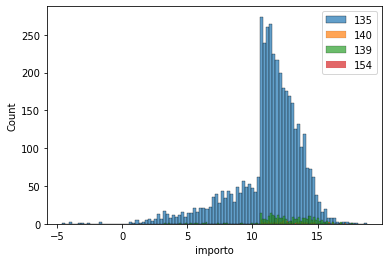

In [15]:
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

for i, forma_giuridica in enumerate(modeMarket.id_forma_giuridica.unique()):
    sns.histplot(
        data=modeMarket[modeMarket.id_forma_giuridica == forma_giuridica], 
        x="importo", bins=100,
        color=list(mcolors.TABLEAU_COLORS)[i], alpha=.7, label=forma_giuridica
    )
    plt.legend()

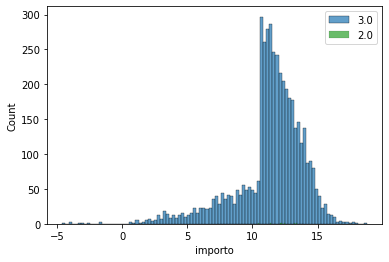

In [16]:
for i, lsf in enumerate(modeMarket.id_lsf.unique()):
    sns.histplot(
        data=modeMarket[modeMarket.id_lsf == lsf], 
        x="importo", bins=100,
        color=list(mcolors.TABLEAU_COLORS)[i], alpha=.7, label=lsf
    )
    plt.legend()

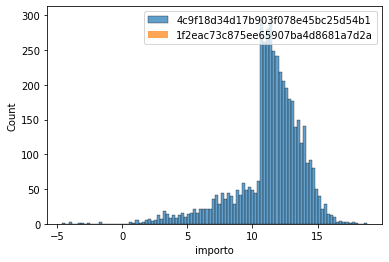

In [17]:
for i, md5 in enumerate(modeMarket.md5.unique()):
    sns.histplot(
        data=modeMarket[modeMarket.md5 == md5], 
        x="importo", bins=100,
        color=list(mcolors.TABLEAU_COLORS)[i], alpha=.7, label=md5
    )
    plt.legend()

In [19]:
modeCPVMarket.id_scelta_contraente.unique().shape

(13,)

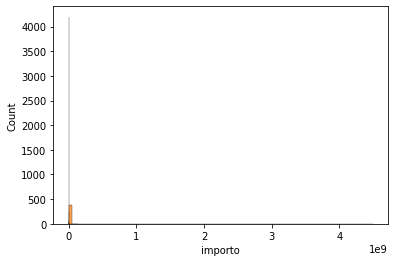

In [20]:
for i, scelta in enumerate(modeCPVMarket.id_scelta_contraente.unique()[:2]):
    sns.histplot(
        data=modeCPVMarket[modeCPVMarket.id_scelta_contraente == scelta],
        x="importo", bins=100,
        color=list(mcolors.TABLEAU_COLORS)[i], alpha=.7, label=scelta
    )